In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

import math

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

import xgboost as xgb

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import torchmetrics

from sklearn.preprocessing import MinMaxScaler

from skorch import NeuralNetRegressor

In [2]:
# read in data on solar panels
sp_data = pd.read_csv('solar_pan_data.csv', encoding='ISO-8859-1')

In [3]:
sp_data.head()

,Date,Sun Hours,Meter 998: Previous,Meter 998: Today,Meter 998: Genreated,Meter 003: Previous,Meter 003: Today,Meter 003: Generated,Totals: Previous,Totals: Today,...,EXP payments: Today,EXP payments: Total,Total Paymets: Today,Total Paymets: Total,Savings: Today,Savings: Total,S+P: Today,S+P: Running Total,Pay Back,Net gain
0,28.9.12,157.1,0,932,932,0,944,944,0,1876,...,£49,£49,£334,£334,£44,£44,£378,£378,"£31,622","-£31,622"
1,30.10.12,76.1,932,1383,451,944,1401,457,1876,2784,...,£24,£73,£162,£496,£21,£65,£183,£561,"£31,439","-£31,439"
2,26.11.12,66.8,1383,1779,396,1401,1803,402,2784,3582,...,£21,£94,£142,£638,£19,£84,£161,£722,"£31,278","-£31,278"
3,31.12.12,67.7,1779,2119,340,1803,2120,317,3582,4239,...,£18,£112,£118,£756,£13,£97,£130,£852,"£31,148","-£31,148"
4,30.1.13,59.3,2119,2491,372,2120,2491,371,4239,4982,...,£17,£129,£130,£886,£27,£124,£157,"£1,009","£30,991","-£30,991"


In [4]:
sp_data.shape

(133, 26)

In [5]:
# check the data types
sp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           133 non-null    object 
 1   Sun Hours                      133 non-null    float64
 2   Meter 998: Previous            133 non-null    int64  
 3   Meter 998: Today               133 non-null    int64  
 4   Meter 998: Genreated           133 non-null    int64  
 5   Meter 003: Previous            133 non-null    int64  
 6   Meter 003: Today               133 non-null    int64  
 7   Meter 003: Generated           133 non-null    int64  
 8   Totals: Previous               133 non-null    int64  
 9   Totals: Today                  133 non-null    int64  
 10  Totals: Period Generated       133 non-null    int64  
 11  Payments: Today                133 non-null    object 
 12  Payments: Total                133 non-null    obj

In [6]:
sp_data.Date.head()

0     28.9.12
1    30.10.12
2    26.11.12
3    31.12.12
4     30.1.13
Name: Date, dtype: object

In [7]:
# convert the Date column to a datetime object
sp_data['Date'] = pd.to_datetime(sp_data['Date'], format='%d.%m.%y')

In [8]:
sp_data.Date.head()

0   2012-09-28
1   2012-10-30
2   2012-11-26
3   2012-12-31
4   2013-01-30
Name: Date, dtype: datetime64[ns]

In [9]:
# add the other weather data 
# then remove unnecessary columns 
# do a correlation plot for spearmans 

In [10]:
#read in the weather data
weather = pd.read_csv('weather.txt')

In [11]:
# select only the columns needed for forecasting 
sp_forecasting = sp_data[['Date', 'Sun Hours', 'Totals: Period Generated']]
sp_forecasting.head()

,Date,Sun Hours,Totals: Period Generated
0,2012-09-28,157.1,1876
1,2012-10-30,76.1,908
2,2012-11-26,66.8,798
3,2012-12-31,67.7,657
4,2013-01-30,59.3,743


In [12]:
#combine the two dfs
forecasting_data = pd.concat([sp_forecasting, weather], axis=1)

In [13]:
forecasting_data.shape

(133, 9)

In [14]:
forecasting_data.drop(labels=['year', 'month'], axis=1, inplace=True)
forecasting_data.head(2)

,Date,Sun Hours,Totals: Period Generated,tmax degC,tmin degC,af days,rain mm
0,2012-09-28,157.1,1876,18.0,9.0,0,46.4
1,2012-10-30,76.1,908,14.0,7.2,2,93.6


In [15]:
# double check for missing values
forecasting_data.isna().sum()

Date                        0
Sun Hours                   0
Totals: Period Generated    0
tmax degC                   0
tmin degC                   0
af days                     0
rain mm                     0
dtype: int64

In [16]:
forecasting_data.describe()

,Date,Sun Hours,Totals: Period Generated,tmax degC,tmin degC,af days,rain mm
count,133,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000
mean,2018-03-31 15:20:18.045112832,126.993233,1532.315789,15.421053,6.813534,3.699248,60.930075
min,2012-09-28 00:00:00,27.200000,291.000000,6.800000,-0.100000,0.000000,3.200000
25%,2015-06-30 00:00:00,73.800000,783.000000,10.700000,3.000000,0.000000,36.400000
50%,2018-04-11 00:00:00,121.900000,1468.000000,14.900000,6.200000,1.000000,57.400000
75%,2021-01-03 00:00:00,170.400000,2139.000000,20.000000,10.500000,7.000000,81.400000
max,2023-09-23 00:00:00,305.600000,3747.000000,25.900000,13.900000,17.000000,166.400000
std,NaN,61.866798,841.165104,5.092434,4.086244,4.708125,34.384653


In [1931]:
# check for any duplicate rows
forecasting_data.duplicated().sum()

0

In [1932]:
# rename columns 
forecasting_data.rename(columns={'Totals: Period Generated': 'Monthly Power Generation', 'af days': 'No. Frost Days', 'rain mm': 'Rain mm'}, inplace=True)

In [1933]:
forecasting_data.columns

Index(['Date', 'Sun Hours', 'Monthly Power Generation', 'tmax degC',
       'tmin degC', 'No. Frost Days', 'Rain mm'],
      dtype='object')

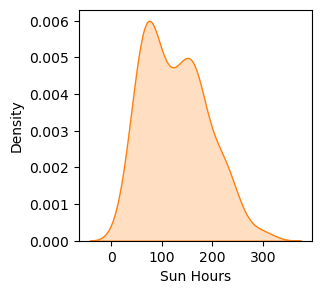

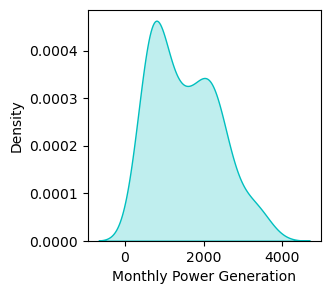

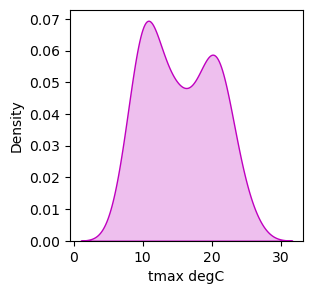

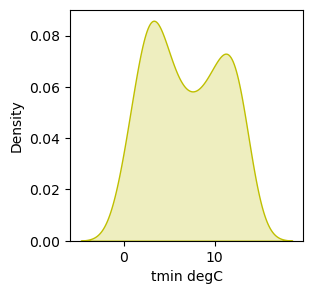

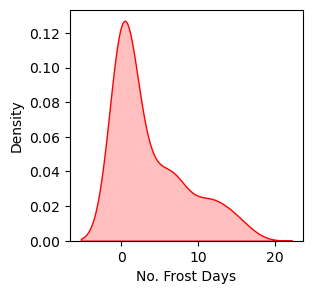

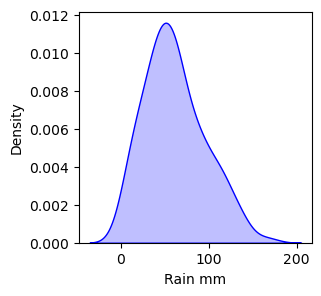

In [1934]:
colours = ['tab:orange', 'c', 'm', 'y', 'r', 'b']
c = 0

for f in forecasting_data.iloc[:,1:7]:
    fig = plt.figure(figsize=(3,3))
    sns.kdeplot(forecasting_data[f], fill=True, color=colours[c])
    c +=1

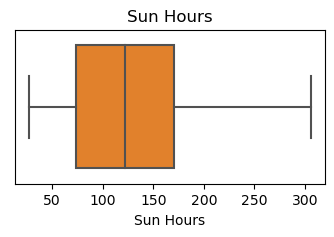

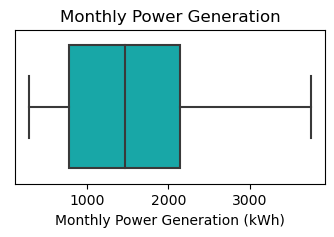

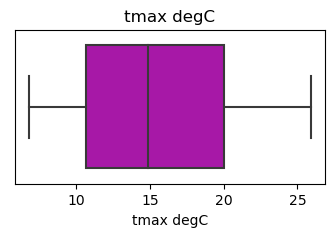

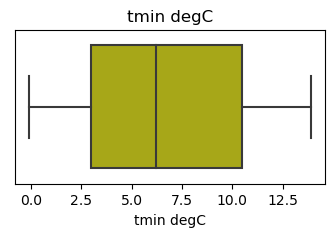

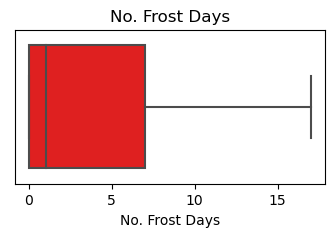

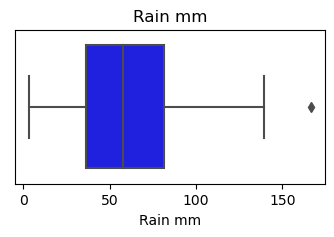

In [1935]:
c=0
for f in forecasting_data.iloc[:,1:7]:
    fig = plt.figure(figsize=(4,2))
    sns.boxplot(forecasting_data[f], color=colours[c], orient='h')
    ax = plt.gca()
    if f == 'Monthly Power Generation':
        ax.set_xlabel(f'{f} (kWh)')
    else:
        ax.set_xlabel(f)   
    ax.yaxis.set_visible(False)
    plt.title(f)
    c+=1
    

In [1936]:
# shapiro wilk test for normality
stat, p = stats.shapiro(forecasting_data['Monthly Power Generation'])
print(stat, p)

# p < 0.05 - reject null hypothesis - data is not normally distributed

0.9469619989395142 5.478189996210858e-05


In [1937]:
f_copy = forecasting_data.copy()
f_copy.drop('Date', axis=1, inplace=True)

In [1938]:
# calculate correlations using spearmans correlation as the 'Totals: Period Generated' variable is not normally distributed
s_corr_matrix = f_copy.corr(method='spearman')

#print(s_corr_matrix)

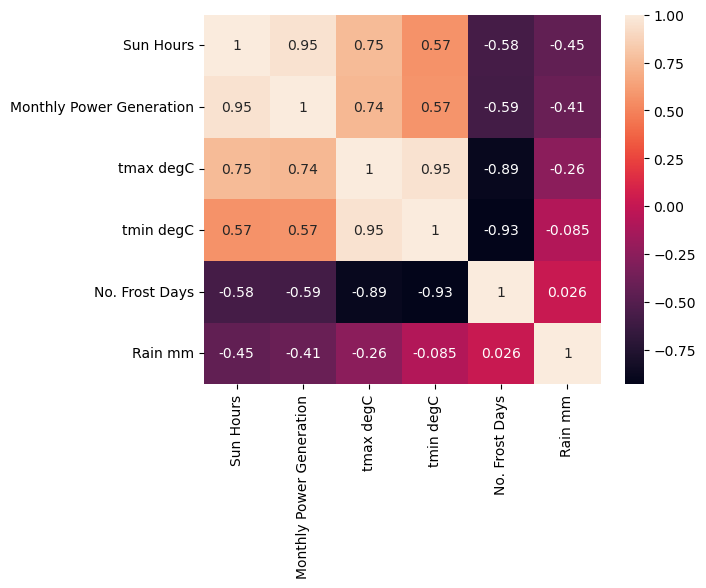

In [1939]:
# display heatmap of the correlation matrix
sns.heatmap(s_corr_matrix, annot=True)
#plt.title('cm')
plt.show()

In [1940]:
# create column to show the monthly mean temp
mean_temp = lambda row: (row['tmin degC'] + row['tmax degC'])/2

forecasting_data['Mean Monthly Temperature'] = forecasting_data.apply(mean_temp, axis=1)

In [1941]:
fd_copy = forecasting_data.copy()
fd_copy.drop('Date', axis=1, inplace=True)

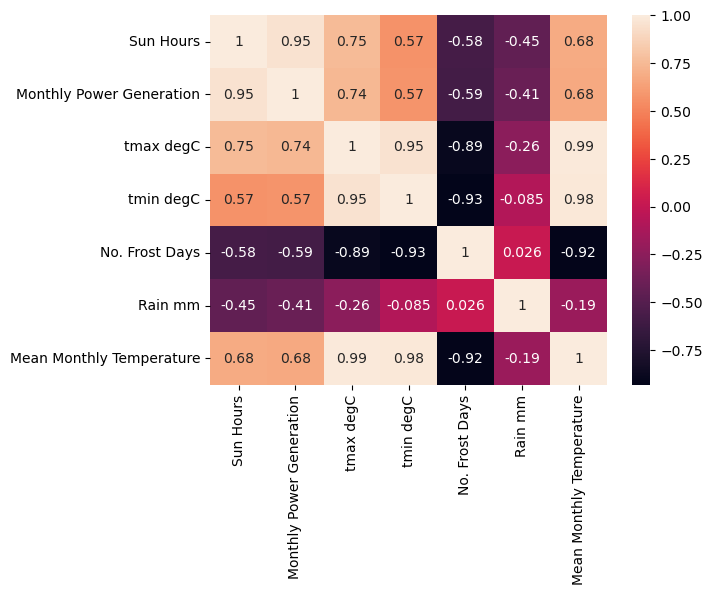

In [1942]:
# new spearmans correlation heatmap to include the monthly mean temperature 
s_corr_matrix = fd_copy.corr(method='spearman')
sns.heatmap(s_corr_matrix, annot=True)
#plt.title('cm')
plt.show()

In [1943]:
exog_vars = ['Sun Hours', 'Mean Monthly Temperature', 'No. Frost Days', 'Rain mm']

spear_corr_dict = {"Spearman's Correlation":[],
                  'p-value': []}

# test p values for the correlations with Monthly Power Generation
for v in exog_vars: 
    corr, p_value = stats.spearmanr(forecasting_data['Monthly Power Generation'], forecasting_data[v])
    spear_corr_dict["Spearman's Correlation"].append(round(corr,4))
    spear_corr_dict['p-value'].append(round(p_value,6))
    print(f'{v}: correlation: {corr}, p value: {p_value}.')

pd.DataFrame(spear_corr_dict, index=exog_vars)

Sun Hours: correlation: 0.9505739885411744, p value: 2.107999868806335e-68.
Mean Monthly Temperature: correlation: 0.6751452567180487, p value: 5.015830241535532e-19.
No. Frost Days: correlation: -0.5852601484859375, p value: 1.380274238093037e-13.
Rain mm: correlation: -0.40694226768423636, p value: 1.168815743142247e-06.


,Spearman's Correlation,p-value
Sun Hours,0.9506,0.000000
Mean Monthly Temperature,0.6751,0.000000
No. Frost Days,-0.5853,0.000000
Rain mm,-0.4069,0.000001


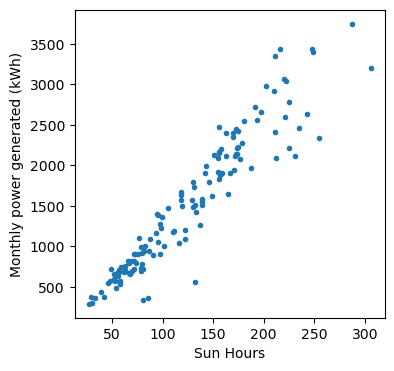

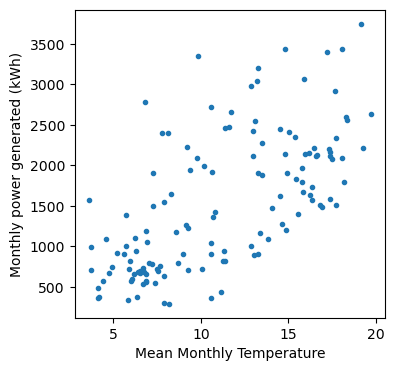

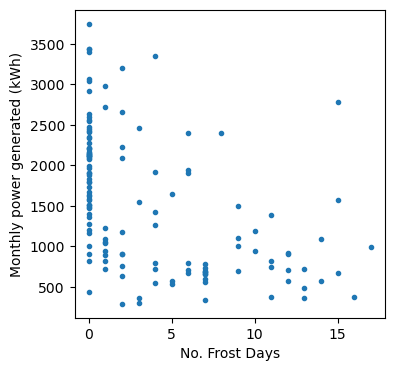

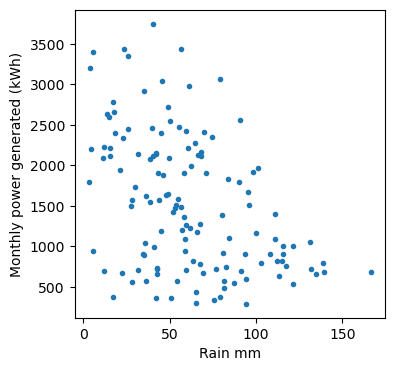

In [1944]:
# series of plots showing each variable with Monthly Power Generation

for v in exog_vars: 
    fig = plt.figure(figsize=(4,4))
    plt.scatter(forecasting_data[v], forecasting_data['Monthly Power Generation'], marker='.')
    plt.xlabel(v)
    plt.ylabel('Monthly power generated (kWh)')
    plt.show()

In [1945]:
# drop original temperature variables as are now replaced with mean monthly temperature
forecasting_data.drop(labels=['tmax degC', 'tmin degC'], axis=1, inplace=True)
forecasting_data.head()

,Date,Sun Hours,Monthly Power Generation,No. Frost Days,Rain mm,Mean Monthly Temperature
0,2012-09-28,157.1,1876,0,46.4,13.50
1,2012-10-30,76.1,908,2,93.6,10.60
2,2012-11-26,66.8,798,6,138.6,7.05
3,2012-12-31,67.7,657,7,135.0,6.20
4,2013-01-30,59.3,743,11,82.4,4.95


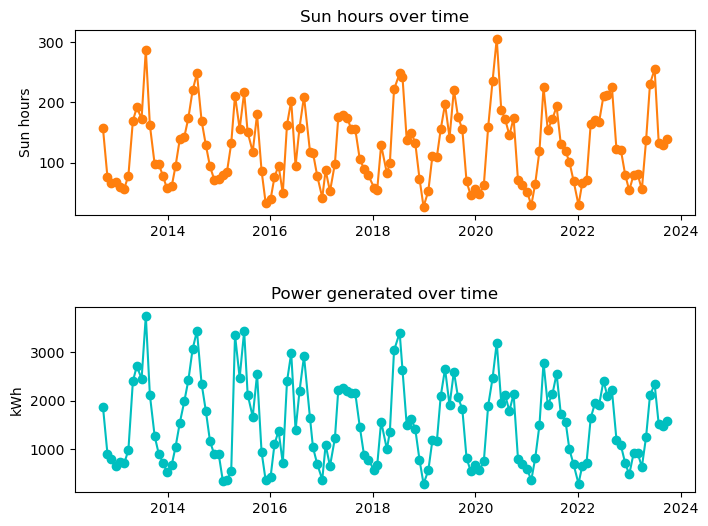

In [1946]:
# plots showing each variable over time 
fig, ax = plt.subplots(2, figsize=(8, 6))


ax[0].plot(forecasting_data.Date, forecasting_data['Sun Hours'], marker='o', color='tab:orange')
ax[0].set_title('Sun hours over time')
ax[0].set_ylabel('Sun hours')

ax[1].plot(forecasting_data.Date, forecasting_data['Monthly Power Generation'], marker='o', color='c')
ax[1].set_ylabel('kWh')
ax[1].set_title('Power generated over time')

fig.subplots_adjust(hspace=0.5)

plt.show()

# shows seasonality 

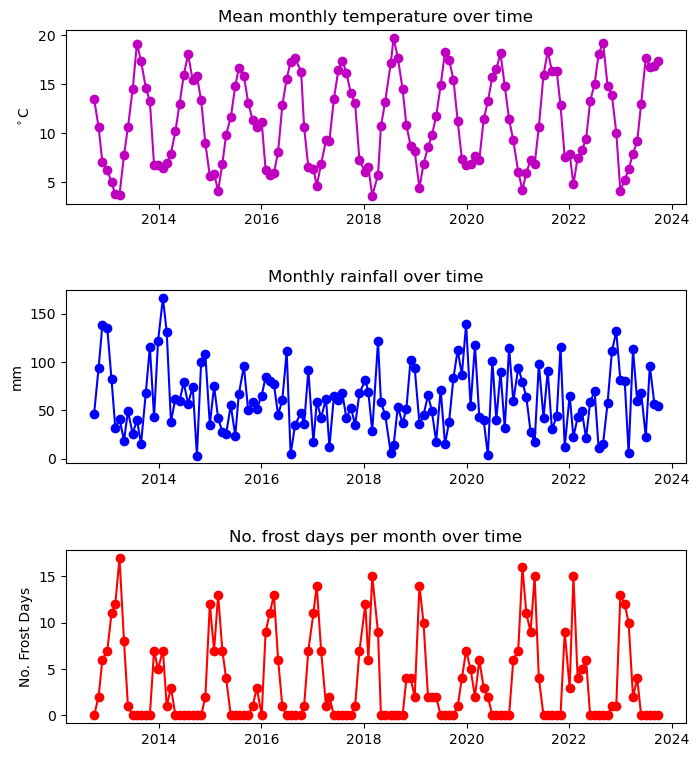

In [1947]:
fig, ax = plt.subplots(3, figsize=(8, 9))

ax[0].plot(forecasting_data.Date, forecasting_data['Mean Monthly Temperature'], marker='o', color='m')
ax[0].set_ylabel('$^\circ$C')
ax[0].set_title('Mean monthly temperature over time')

ax[1].plot(forecasting_data.Date, forecasting_data['Rain mm'], marker='o', color='b')
ax[1].set_ylabel('mm')
ax[1].set_title('Monthly rainfall over time')

ax[2].plot(forecasting_data.Date, forecasting_data['No. Frost Days'], marker='o', color='r')
ax[2].set_ylabel('No. Frost Days')
ax[2].set_title('No. frost days per month over time')

fig.subplots_adjust(hspace=0.5)

plt.show()

In [1948]:
# set the date to the index
forecasting_data.set_index('Date', inplace=True)

In [1949]:
#rolling mean and std for each 12 month period 

forecasting_data["rolling_avg"] = forecasting_data['Monthly Power Generation'].rolling(window=12).mean() 
forecasting_data["rolling_std"] = forecasting_data['Monthly Power Generation'].rolling(window=12).std()

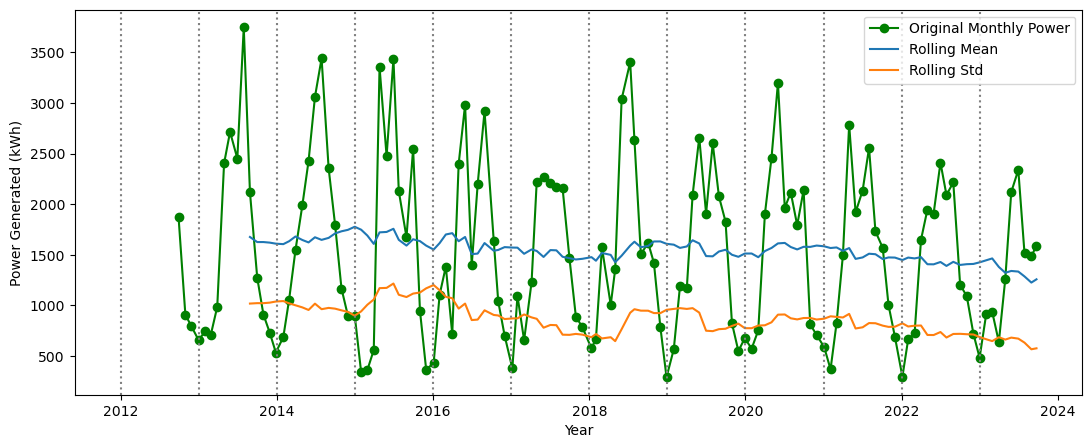

In [1950]:
# plot of original monthly power generation, rolling mean and rolling std for 12 month periods  

plt.figure(figsize=(13,5))
plt.plot(forecasting_data.index, forecasting_data['Monthly Power Generation'], marker='o', color='g', label='Original Monthly Power')
plt.plot(forecasting_data['rolling_avg'], label = 'Rolling Mean')
plt.plot(forecasting_data['rolling_std'], label='Rolling Std')
plt.xlabel('Year')
plt.ylabel('Power Generated (kWh)')

# add dotted line for each year
for y in forecasting_data.index.year.unique():
    plt.axvline(pd.to_datetime(str(y)), color='gray', linestyle='dotted')

plt.legend()
plt.show()


# appears to be a slight downward trend

In [1951]:
# Agumented Dickey-Fuller test if data is stationary. Use AIC to automatically select the number of lags

adf_test = adfuller(forecasting_data['Monthly Power Generation'], autolag='AIC')

In [1952]:
# outputs of the test
adf_test


# Null Hypothesis (HO): Series is non-stationary
# if p-value < 0.05 and test statistic < Critical Value  - Reject Null Hypothesis(HO)

# p value greater than significance value of 0.05
# statistic is greater than critical values 
# dont reject hull hypothesis 
# the adf test result suggests the data is non-stationary 

(-0.5409610170745163,
 0.8837723622180571,
 13,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 1792.419094341015)

In [1953]:
# check if 1 differencing makes the data stationary 
fd_diff = forecasting_data.diff().dropna()

In [1954]:
adf_test_2 = adfuller(fd_diff['Monthly Power Generation'], autolag='AIC')
adf_test_2

# now the p value is < 0.05 - reject the null hypothesis 
# the data is now stationary 

(-7.945977982665155,
 3.219251201048848e-12,
 12,
 108,
 {'1%': -3.4924012594942333,
  '5%': -2.8886968193364835,
  '10%': -2.5812552709190673},
 1617.3484045355672)

In [1955]:
# perform seasonal differencing to check the affect on the data

fd_seas_diff = forecasting_data.diff(12).dropna()

adf_test_3 = adfuller(fd_seas_diff['Monthly Power Generation'], autolag='AIC')
adf_test_3

# seasonal differencing also makes the data stationary 

(-3.599279624921696,
 0.005774814720311757,
 11,
 98,
 {'1%': -3.4989097606014496,
  '5%': -2.891516256916761,
  '10%': -2.5827604414827157},
 1472.8255223732947)

C:\Users\afwil\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


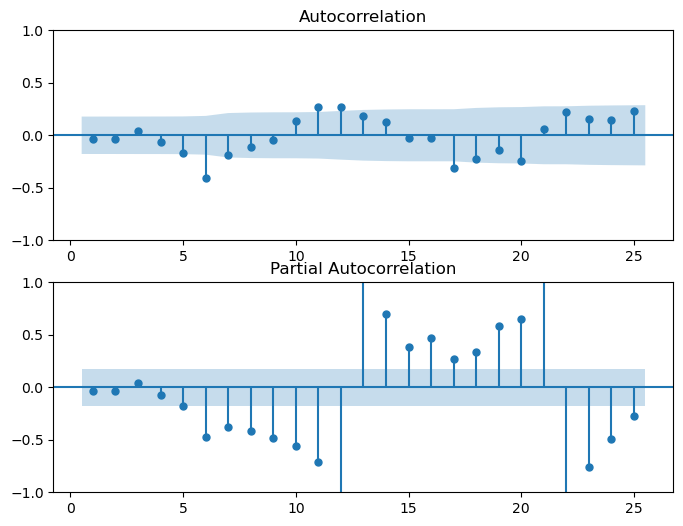

In [1956]:
# acf and pacf plots for the differenced data 
fig, ax = plt.subplots(2, figsize=(8,6))

plot_acf(fd_diff['Monthly Power Generation'], ax=ax[0], lags=25, zero=False)
plot_pacf(fd_diff['Monthly Power Generation'], ax=ax[1], lags=25, zero=False)
plt.show()

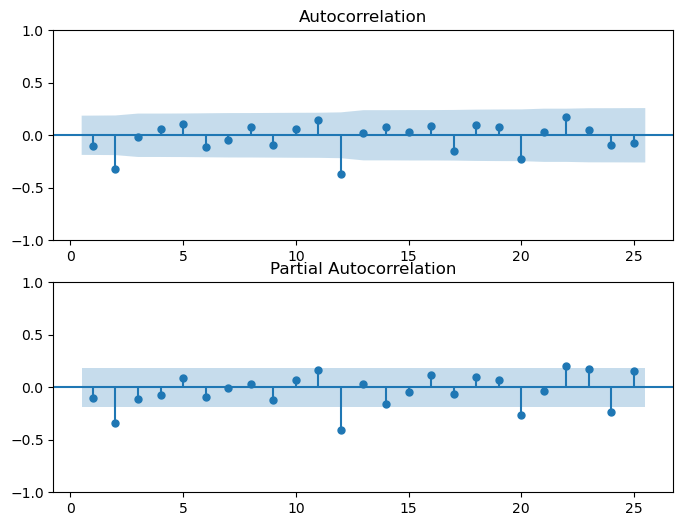

In [1957]:
# acf and pcaf plots for the seasonally differenced data
fig, ax = plt.subplots(2, figsize=(8,6))

plot_acf(fd_seas_diff ['Monthly Power Generation'], ax=ax[0], lags=25, zero=False)
plot_pacf(fd_seas_diff ['Monthly Power Generation'], ax=ax[1], lags=25, zero=False)
plt.show()

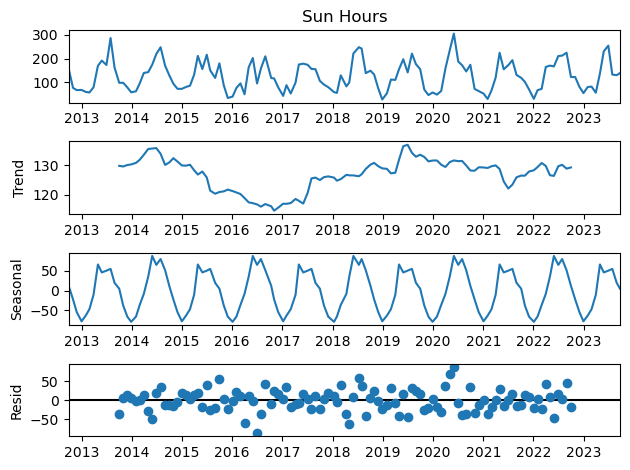

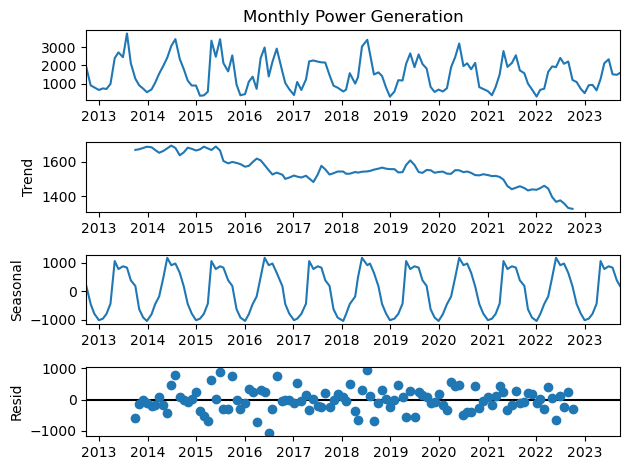

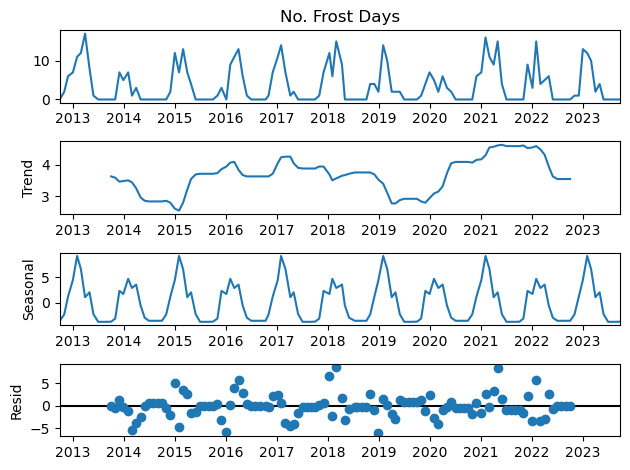

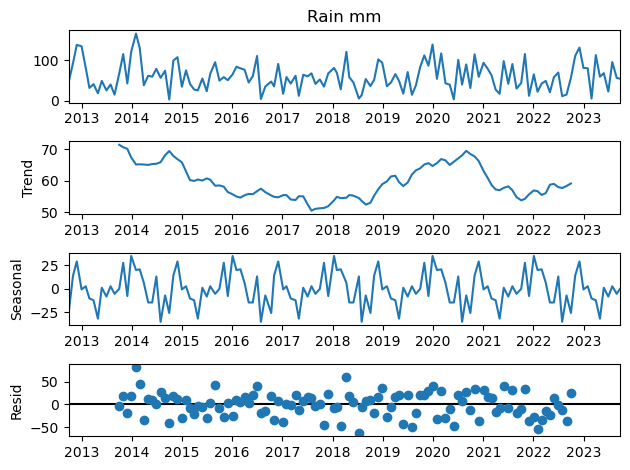

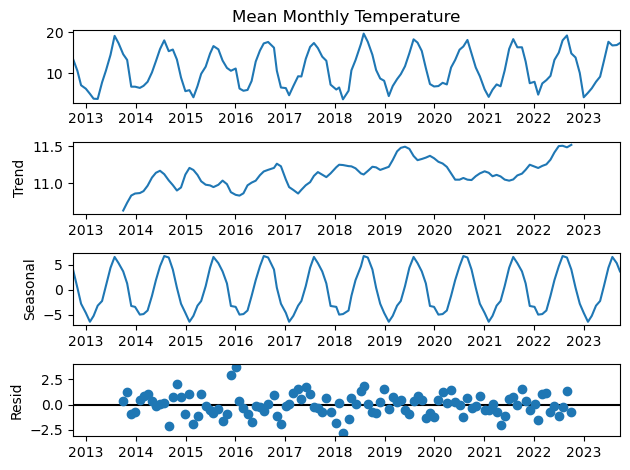

ValueError: This function does not handle missing values

In [1958]:
# decompose the TS to show the trend and seasonality for each feature  
for feature in forecasting_data.columns:
    decomposed_data = seasonal_decompose(forecasting_data[feature], period=24)
    decomposed_data.plot()
    plt.show()

In [ ]:
# examing the exogenous features for stationarity and seasonality

In [1959]:
# check if the exogenous features are stationary 
def exogenous_features_stationary(df):
    '''Take a data frame and perform the adf test for each column'''
    exog_adf_dict = {'ADF p-value': []}
    for feature in df.columns:
        adf_test_result = adfuller(df[feature], autolag='AIC')
        #exog_adf_dict['feature'].append(feature)
        exog_adf_dict['ADF p-value'].append(round(adf_test_result[1], 4))
        print(f'{feature}, ADF result: {adf_test_result[1]}')
    
    exog_adf_df = pd.DataFrame(exog_adf_dict, index=df.columns)       
    return exog_adf_df

In [1960]:
exogenous_features_stationary(forecasting_data.iloc[:,[0,2,3,4]])

Sun Hours, ADF result: 3.201013131746944e-15
No. Frost Days, ADF result: 4.940971588153164e-12
Rain mm, ADF result: 4.767830242599052e-09
Mean Monthly Temperature, ADF result: 0.0074101304143403025


,ADF p-value
Sun Hours,0.0000
No. Frost Days,0.0000
Rain mm,0.0000
Mean Monthly Temperature,0.0074


In [1961]:
# exogenous features have stationary data according to adf - no trend

C:\Users\afwil\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


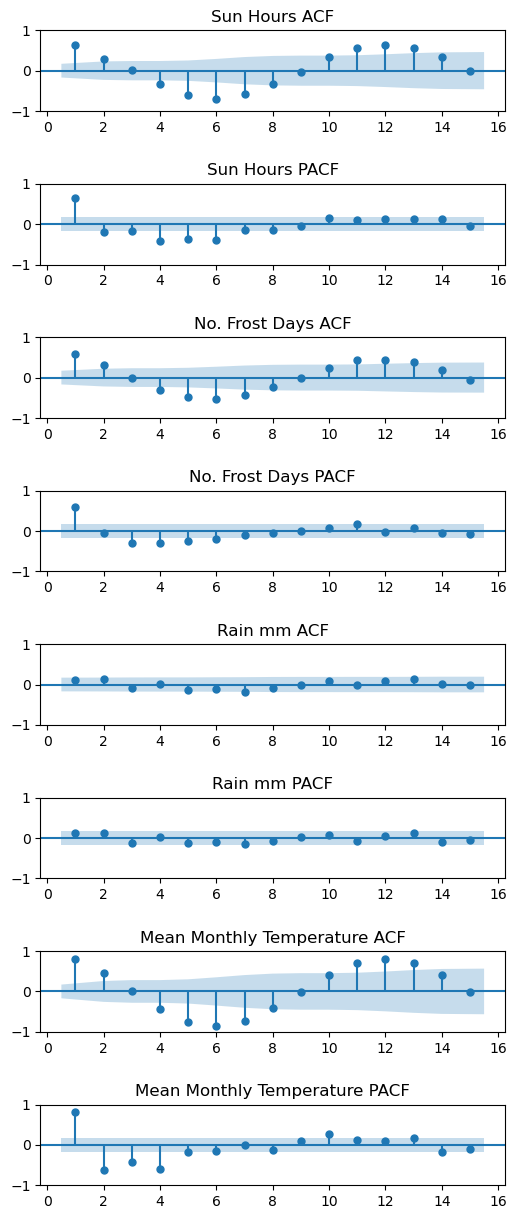

In [1962]:
fig, ax = plt.subplots(8, figsize=(6,15))

i = 0
# plot acf and pacf plots for the exogenous features 
for feature in forecasting_data.iloc[:,[0,2,3,4]].columns:
    plot_acf(forecasting_data[feature], ax=ax[i], lags=15, zero=False)
    ax[i].set_title(f'{feature} ACF')
    i +=1
    plot_pacf(forecasting_data[feature], ax=ax[i], lags=15, zero=False)
    ax[i].set_title(f'{feature} PACF')
    i +=1
    


fig.subplots_adjust(hspace=0.9)

                                                   
plt.show()

In [1963]:
# work out the how often the seasonal component is repeated 
# detrend first as there is a trend in the data

detrend_fd = forecasting_data - forecasting_data.rolling(24).mean()

In [1964]:
# drop na values
detrend_fd = detrend_fd.dropna()

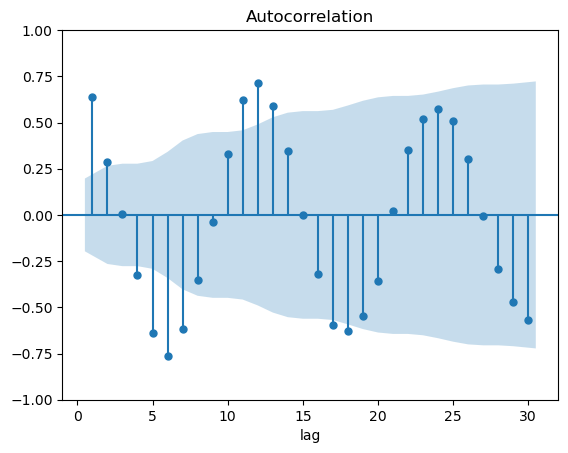

In [1965]:
# plot the detrended data 
# observe the lag >1 which is also a peak in the plot
fig, ax = plt.subplots(1)

plot_acf(detrend_fd['Monthly Power Generation'], ax=ax, lags=30, zero=False)
plt.xlabel('lag')
plt.show()

# as expected, the seasonal component repeats every 12 data points - yearly 
# s in the SARIMAX model will = 12

In [1683]:
# remove the rolling mean and rolling standard deviation from the data frame
forecasting_data.drop(labels=['rolling_avg', 'rolling_std'], axis=1, inplace=True)

In [1684]:
# split into train test data so the test set is the final 12 months 
def train_test_split(df, percent_train):
    train_size = int(len(df) * percent_train)
    train, test = df[:train_size], df[train_size:]
    return train, test

In [1685]:
train, test = train_test_split(forecasting_data, 0.91)

In [1686]:
len(test)

12

Text(0.5, 1.0, 'Montly Power Generated for the training set and the test set')

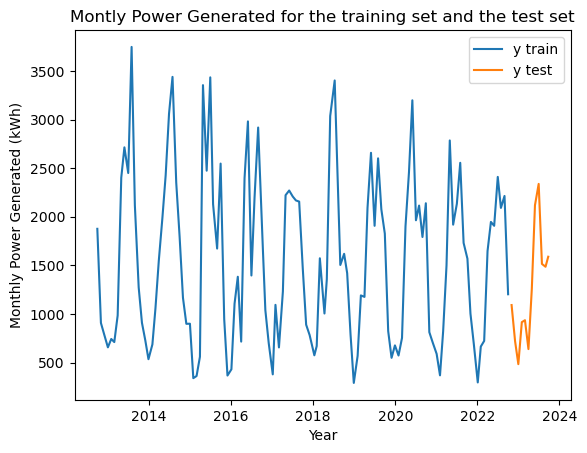

In [1688]:
#plot to show the train sets split
plt.plot(train['Monthly Power Generation'], label='y train')
plt.plot(test['Monthly Power Generation'], label = 'y test')
plt.legend(loc='upper right')
plt.xlabel('Year')
plt.ylabel('Monthly Power Generated (kWh)')
plt.title('Montly Power Generated for the training set and the test set')


In [1689]:
# SARIMAX model
# test models to find optimal values for p,q,P, Q

# function to test SARIMAX models 
def test_sarimax_models(data, d, D):
    model = pm.auto_arima(data['Monthly Power Generation'], exogenous=[data['Sun Hours'], data['Mean Monthly Temperature'],
                                                                      data['No. Frost Days'], data['Rain mm']],
                           d=d, start_p=0, start_q=0, seasonal=True, m=12, D=D, start_P=0, start_Q=0, information_criterion='aic',
                           trace=True, error_action='ignore', stepwise=True)
    return model


In [1690]:
# test models where d = 1 and D = 0 
mod_d1 = test_sarimax_models(train, 1, 0)
# test models where d = 0 and D = 1
mod_D1 = test_sarimax_models(train, 0, 1)
#test models where d=1 and D=1
mod_d1_D1 = test_sarimax_models(train, 1, 1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1926.731, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1913.423, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1917.616, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1924.740, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1928.419, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1911.474, Time=0.29 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1918.033, Time=0.19 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1898.591, Time=0.42 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1905.623, Time=0.19 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1891.914, Time=0.79 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1880.054, Time=0.41 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1918.796, Time=0.13 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [1691]:

def sort_models(models_lisst): 
    '''Function to create a df of the models, their details and the AIC'''
    best_mods = []
    for mod in models:
        tup = (str(mod), mod.order, mod.seasonal_order, mod.aic())
        best_mods.append(tup)
    # save model info to a df
    models_df = pd.DataFrame(best_mods, columns=['Model', 'Order', 'Seasonal order', 'AIC'])  
    # sort from lowest to highest AIC 
    mod_df_sorted = models_df.sort_values('AIC')
    return mod_df_sorted
    

In [1692]:
models = [mod_d1, mod_D1, mod_d1_D1]
sort_models(models)

,Model,Order,Seasonal order,AIC
2,"ARIMA(2,1,2)(2,1,1)[12]","(2, 1, 2)","(2, 1, 1, 12)",1638.254747
1,"ARIMA(2,0,0)(2,1,1)[12] intercept","(2, 0, 0)","(2, 1, 1, 12)",1645.817225
0,"ARIMA(3,1,0)(1,0,1)[12] intercept","(3, 1, 0)","(1, 0, 1, 12)",1873.186140


In [1693]:
# fit the best model 

result = mod_d1_D1.fit(train['Monthly Power Generation'])


In [1694]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  121
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -811.127
Date:                              Tue, 05 Dec 2023   AIC                           1638.255
Time:                                      15:57:00   BIC                           1659.712
Sample:                                           0   HQIC                          1646.955
                                              - 121                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2031      0.338      0.602      0.547      -0.458       0.865
ar.L2         -0.2648      0.103     -2.575      0.010      -0.466      -0.063
ma.L1         -1.3218      0.354     -3.733      0.000      -2.016      -0.628
ma.L2          0.3317      0.325      1.021      0.307      -0.305       0.968
ar.S.L12       0.0007      0.165      0.004      0.997      -0.323       0.325
ar.S.L24      -0.1056      0.129     -0.817      0.414      -0.359       0.148
ma.S.L12      -0.8165      0.252     -3.244      0.001      -1.310      -0.323
sigma2      1.656e+05    3.8e+04      4.361      0.000    9.12e+04     2.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                10.76
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.33
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

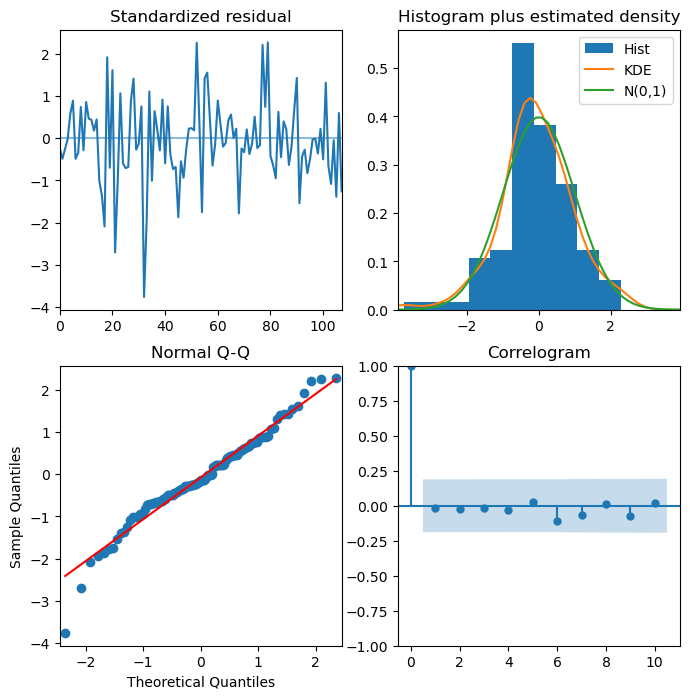

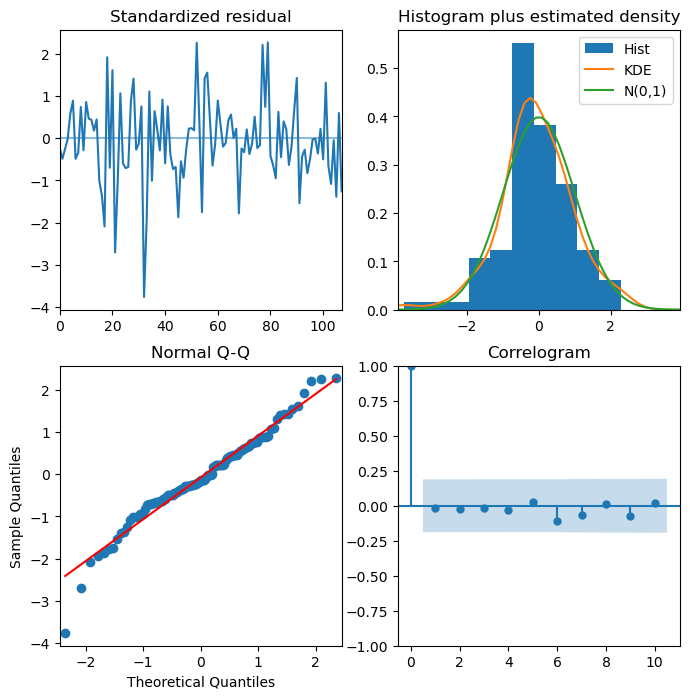

In [1695]:
# show plot diagnositics - shows the distribution, correlation, and structure of residuals
result.plot_diagnostics(figsize=(8,8))

In [1696]:
# forecast the results for the test data
forecast = result.predict(n_periods=len(test))

C:\Users\afwil\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [1697]:
# calculate the RMSE for the predictions
sarimax_rmse = mean_squared_error(test['Monthly Power Generation'], forecast, squared=False)

In [1698]:
# RMSE for original model - without seasonality removed from exogenous features 
sarimax_rmse

429.6949624423171

In [1699]:
# prepare the test time series and the predictions to be plotted
test_s = test.reset_index()
forecast_series = pd.DataFrame(forecast, columns=['Predicted Power']).reset_index().drop('index', axis=1)
sm_true_and_predicted = pd.concat([test_s, forecast_series], axis=1)

In [1823]:
# plot the true values of power and the predictions

def plot_model(df):
    plt.figure(figsize=(14,6))
    plt.plot(df.Date, df['Monthly Power Generation'], label='True Power Generation')
    plt.plot(df.Date, df['Predicted Power'], color='r', label='Predicted Power Generation')
    plt.title('True Power Values vs Predicted Power Values')
    plt.xlabel('Year')
    plt.ylabel('Power Generation (kWh)')
    
    plt.legend(loc='lower left')

    return plt.show()

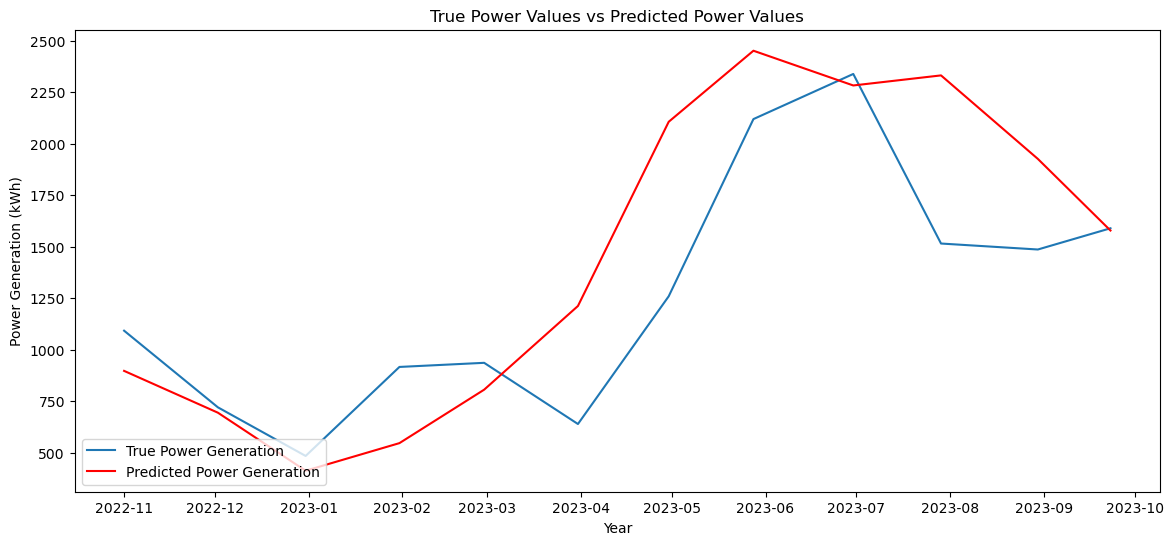

In [1824]:
plot_model(sm_true_and_predicted)

In [1702]:
# remove the seasonality from the exogenous feature displaying seasonality 

In [1703]:
exog_seas_fd = forecasting_data.copy()

In [1704]:
# seasonaly difference seasonal exogenous features
for feature in exog_seas_fd.iloc[:, [0,2,4]].columns:
    sd_feature = exog_seas_fd[feature].diff(12)
    exog_seas_fd[feature] = sd_feature    

In [1705]:
exog_seas_fd.dropna(inplace=True)

In [1706]:
es_train, es_test = train_test_split(exog_seas_fd, 0.905)

In [1707]:
# test models

# test models where d = 1 and D = 0 
es_mod_d1 = test_sarimax_models(train, 1, 0)
# test models where d = 0 and D = 1
es_mod_D1 = test_sarimax_models(train, 0, 1)
#test models where d=1 and D=1
es_mod_d1_D1 = test_sarimax_models(train, 1, 1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1926.731, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1913.423, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1917.616, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1924.740, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1928.419, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1911.474, Time=0.23 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1918.033, Time=0.17 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=1898.591, Time=0.33 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1905.623, Time=0.16 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1891.914, Time=0.78 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1880.054, Time=0.37 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1918.796, Time=0.14 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [1708]:
es_models = [es_mod_d1, es_mod_D1, es_mod_d1_D1]
sort_models(es_models)

,Model,Order,Seasonal order,AIC
2,"ARIMA(2,1,2)(2,1,1)[12]","(2, 1, 2)","(2, 1, 1, 12)",1638.254747
1,"ARIMA(2,0,0)(2,1,1)[12] intercept","(2, 0, 0)","(2, 1, 1, 12)",1645.817225
0,"ARIMA(3,1,0)(1,0,1)[12] intercept","(3, 1, 0)","(1, 0, 1, 12)",1873.186140


In [1709]:
# is the same model as before

In [1710]:
es_result = es_mod_d1_D1.fit(es_train['Monthly Power Generation'])


In [1711]:
es_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -728.457
Date:                              Tue, 05 Dec 2023   AIC                           1472.914
Time:                                      15:59:40   BIC                           1493.428
Sample:                                           0   HQIC                          1481.206
                                              - 109                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8553      0.129      6.616      0.000       0.602       1.109
ar.L2         -0.0157      0.142     -0.110      0.912      -0.295       0.263
ma.L1         -1.9358      0.078    -24.728      0.000      -2.089      -1.782
ma.L2          0.9522      0.075     12.696      0.000       0.805       1.099
ar.S.L12      -0.0675      0.227     -0.297      0.766      -0.512       0.377
ar.S.L24      -0.1713      0.164     -1.041      0.298      -0.494       0.151
ma.S.L12      -0.8905      0.527     -1.691      0.091      -1.923       0.142
sigma2      1.962e+05   7.94e+04      2.473      0.013    4.07e+04    3.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 2.75
Prob(Q):                              0.87   Prob(JB):                         0.25
Heteroskedasticity (H):               0.47   Skew:                            -0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

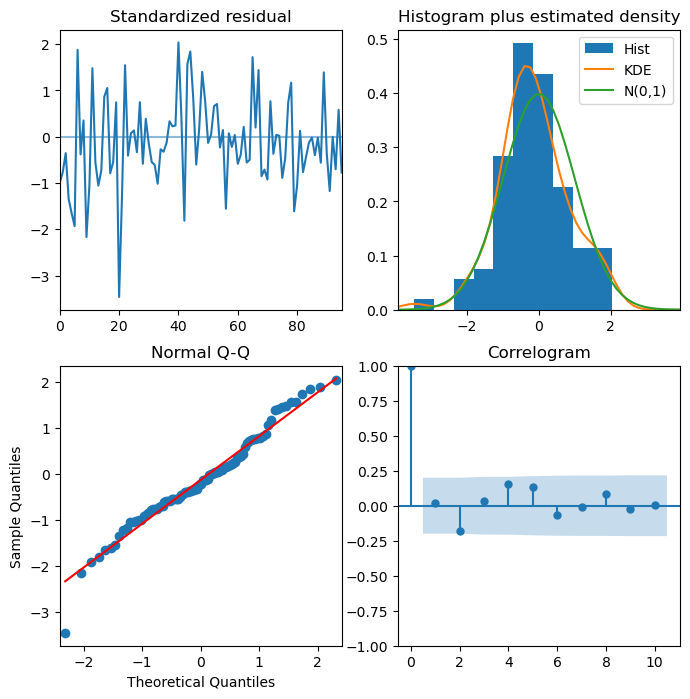

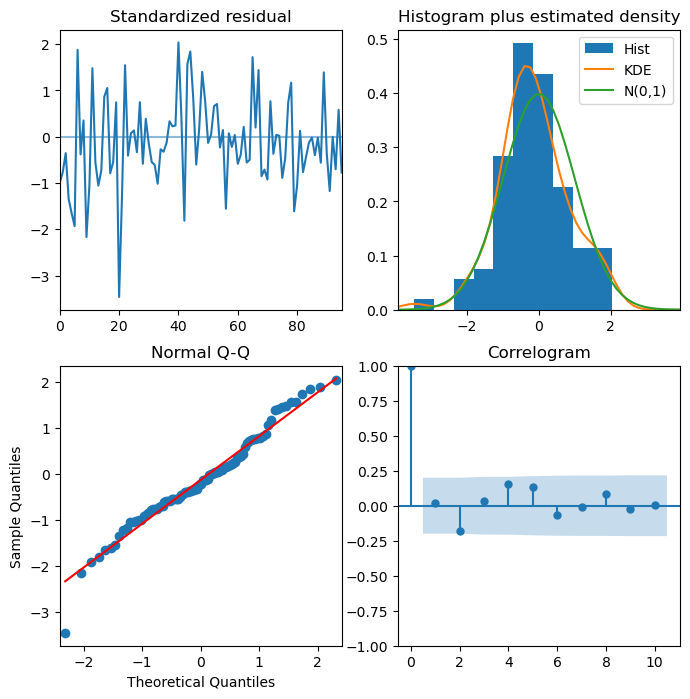

In [1828]:
es_result.plot_diagnostics(figsize=(8,8))

In [1713]:
es_forecast = es_result.predict(n_periods=len(es_test))
es_sarimax_rmse = mean_squared_error(es_test['Monthly Power Generation'], es_forecast, squared=False)
es_sarimax_rmse

C:\Users\afwil\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


363.5135832534713

In [1714]:
# seasonal differencing of seasonal exogenous features appears to have improved rmse 

In [1715]:
es_test_s = es_test.reset_index()
es_forecast_series = pd.DataFrame(es_forecast, columns=['Predicted Power']).reset_index().drop('index', axis=1)
es_sm_true_and_predicted = pd.concat([es_test_s, es_forecast_series], axis=1)

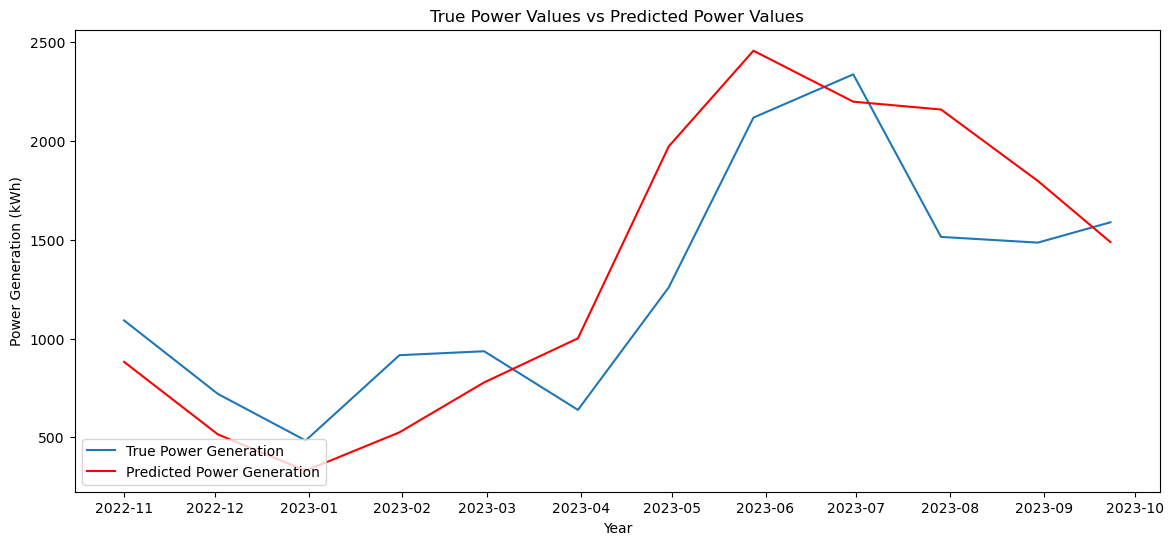

In [1825]:
plot_model(es_sm_true_and_predicted)

**XGB model**

In [1717]:

def lagged_dataset(df, start_lag, total_lags, target):
    '''Take a time series and create columns for the lagged features in order to frame as a supervised learning dataset'''
    cols_to_drop = []
    lagged_columns = []
    
    # loop through features in the df
    for feature in df.columns:
        # create a feature for each lag 
        for lag in range(start_lag, total_lags+1):
            lagged_column = df[feature].shift(lag)
            lagged_column.rename(f'{feature} lag_{lag}', inplace=True)
            lagged_columns.append(lagged_column)
            
        # if the feature is not the target, drop it from the df
        if feature != target:
            cols_to_drop.append(feature)
            
    df.drop(cols_to_drop, axis = 1, inplace=True)
    
    # combine the lagged columns
    cols_concat = pd.concat(lagged_columns, axis=1)
    
    # add the lagged columns to the df
    lagged_df = pd.concat([df, cols_concat], axis=1)
    
    # drop columns with missing values from the df
    lagged_df.dropna(inplace=True)
    return lagged_df
        

In [1718]:
# create a copy of the forecasting_data df to used with the XGB model 

xgb_fd = forecasting_data.copy()

In [1719]:
# create the dataset containing the target of Monthly Power Generation and the lagged columns for the other variables 
xgb_dataset = lagged_dataset(xgb_fd, 12, 36, 'Monthly Power Generation')

In [1720]:
len(xgb_dataset)

97

In [1721]:
# create the training and testing sets from the xgb dataframe
# test set to be the final 12 months
xgb_train, xgb_test = train_test_split(xgb_dataset, 0.88)

In [1722]:
len(xgb_test)

12

In [1723]:
xgb_train.columns

Index(['Monthly Power Generation', 'Sun Hours lag_12', 'Sun Hours lag_13',
       'Sun Hours lag_14', 'Sun Hours lag_15', 'Sun Hours lag_16',
       'Sun Hours lag_17', 'Sun Hours lag_18', 'Sun Hours lag_19',
       'Sun Hours lag_20',
       ...
       'Mean Monthly Temperature lag_27', 'Mean Monthly Temperature lag_28',
       'Mean Monthly Temperature lag_29', 'Mean Monthly Temperature lag_30',
       'Mean Monthly Temperature lag_31', 'Mean Monthly Temperature lag_32',
       'Mean Monthly Temperature lag_33', 'Mean Monthly Temperature lag_34',
       'Mean Monthly Temperature lag_35', 'Mean Monthly Temperature lag_36'],
      dtype='object', length=126)

In [1830]:
# create the features sets and the target sets
X_train = xgb_train.drop(['Monthly Power Generation'], axis=1)
y_train = xgb_train[['Monthly Power Generation']]
X_test = xgb_test.drop(['Monthly Power Generation'], axis=1)
y_test = xgb_test[['Monthly Power Generation']]

In [1725]:
# XGBoost model 

# create the time series split for the random search
ts_split = TimeSeriesSplit(n_splits=6, test_size=12)

In [1726]:
# for i, (train_index, test_index) in enumerate(ts_split.split(X_train)):
#     print(f"Fold {i}:")
#     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

In [1833]:
# define the model 
xgb_r = xgb.XGBRegressor()

# define a dictionary of HPs to test 

parameters = {
    'n_estimators': np.arange(100, 600, 100),
    'max_depth': [3, 4, 5, 6],
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'gamma': np.arange(0, 10, 0.1),
    'lambda': np.arange(0, 5, 0.1),
    'colsample_bytree': np.arange(0.3, 0.9, 0.1)
}

In [1733]:
# grid search for best model
r_search = RandomizedSearchCV(estimator=xgb_r, cv=ts_split, param_distributions=parameters, scoring='neg_root_mean_squared_error', n_iter=500)

xgb_model = r_search.fit(X_train, y_train)

In [1734]:
# show the best hyperparameter scores
print('hyperparameters: ',r_search.best_params_)
print(abs(r_search.best_score_))

hyperparameters:  {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.03, 'lambda': 1.9000000000000001, 'gamma': 2.7, 'colsample_bytree': 0.3}
402.5414874821995


In [1735]:
# make predictions from the model for the test set
xgb_predictions = xgb_model.predict(X_test)

In [1736]:
xgb_predictions

array([1108.9974 ,  675.5136 ,  582.597  ,  848.9641 ,  983.67334,
       1441.5321 , 2167.1992 , 2709.561  , 2285.43   , 2383.5942 ,
       1904.8153 , 1851.2433 ], dtype=float32)

In [1737]:
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

In [1738]:
xgb_rmse

486.2954500264726

In [1739]:
test_series = xgb_test.reset_index()
pred_series = pd.DataFrame(xgb_predictions, columns=['Predicted Power'])
xgb_test_and_predicted = pd.concat([test_series, pred_series], axis=1)

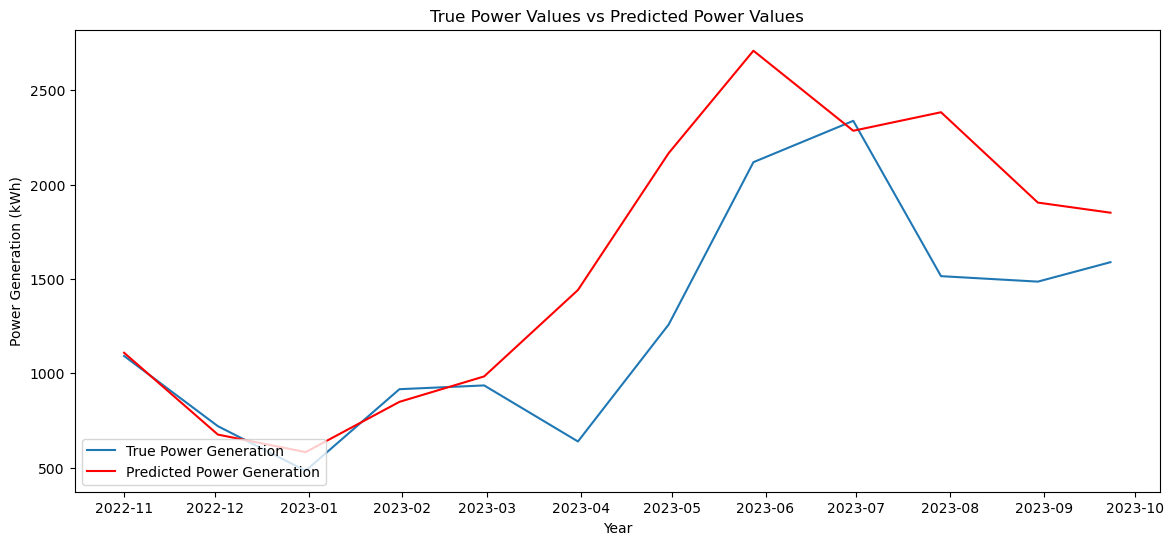

In [1826]:
# plot the true values and the predicted 
plot_model(xgb_test_and_predicted)

XGB with normalisation

In [1829]:
norm = MinMaxScaler()

In [1831]:
# normalise the training and testing sets

X_train_normed = norm.fit_transform(X_train)
y_train_normed = norm.fit_transform(y_train)
X_test_normed = norm.fit_transform(X_test)
y_test_normed = norm.fit_transform(y_test)

In [1834]:
# use the same XGBregressor and the parameters defined above to test models with the normalised training test

# grid search for best model
norm_r_search = RandomizedSearchCV(estimator=xgb_r, cv=ts_split, param_distributions=parameters, scoring='neg_root_mean_squared_error', n_iter=500)

norm_xgb_model = norm_r_search.fit(X_train_normed, y_train_normed)

In [1835]:
# show the best hyperparameter scores
print('hyperparameters: ',norm_r_search.best_params_)
print(abs(norm_r_search.best_score_))

hyperparameters:  {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.43, 'lambda': 4.0, 'gamma': 0.0, 'colsample_bytree': 0.3}
0.138527126774689


In [1836]:
norm_xgb_predictions = norm_xgb_model.predict(X_test_normed)

In [1837]:
norm_xgb_predictions

array([0.3467968 , 0.1434599 , 0.1388061 , 0.19790414, 0.16802278,
       0.3856895 , 0.50548697, 0.5685192 , 0.6801616 , 0.60825205,
       0.54598737, 0.36030933], dtype=float32)

In [1840]:
# unnormalise the xgb predictions
rescaled_xgb_predictions = norm.inverse_transform(norm_xgb_predictions.reshape(-1,1))

In [1842]:
norm_xgb_rmse = mean_squared_error(y_test, rescaled_xgb_predictions, squared=False)

In [1843]:
norm_xgb_rmse

331.8956605945936

In [1844]:
test_series = xgb_test.reset_index()

norm_xgb_pred_series = pd.DataFrame(rescaled_xgb_predictions, columns=['Predicted Power'])
norm_xgb_test_and_predicted = pd.concat([test_series, norm_xgb_pred_series], axis=1)

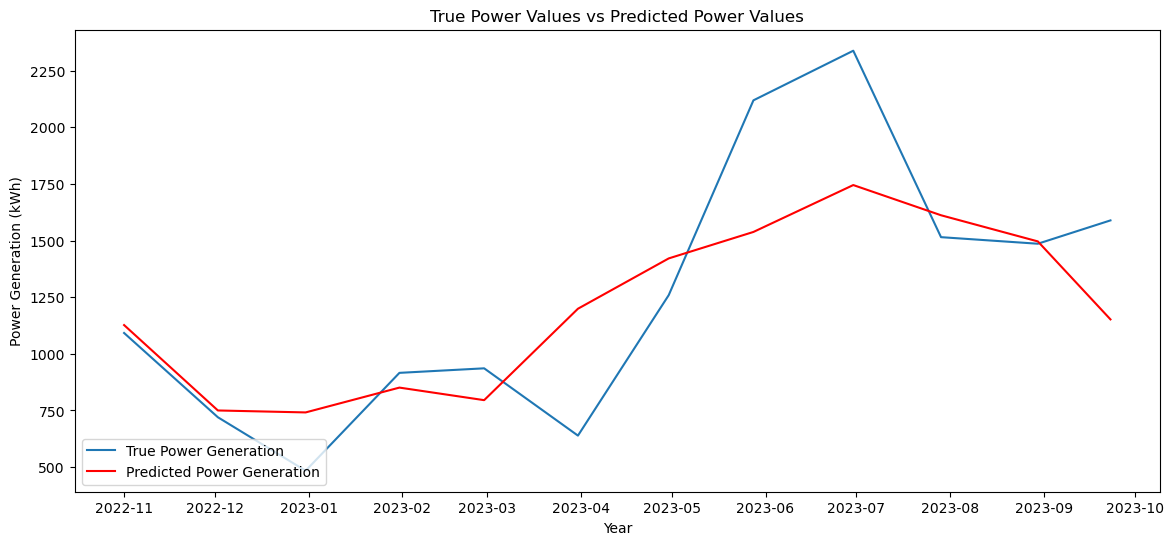

In [1846]:
plot_model(norm_xgb_test_and_predicted)

**LSTM-RNN model**

Data prep for the model:

In [1741]:
#forecasting_data = forecasting_data.diff().diff(12).dropna()

In [1742]:
# create the training and testing sets from the xgb dataframe

DL_train, DL_test = train_test_split(forecasting_data, 0.72)

In [1743]:
print(len(DL_train))
len(DL_test)

95


38

In [1744]:
#DL_train

In [1745]:
# create the sequences 
def create_dataset_sequences(df, seq_len, forecast_len): 
    '''Take a dataframe, a sequence length and a period to forecast.
    Create the sequences for predictions.'''
    xs = []
    ys = []
    for i in range(len(df) - seq_len - forecast_len + 1):
        # select the features
        x = df.iloc[i:i+seq_len,].values
        # select the targets
        y = df.iloc[i+seq_len:i+seq_len+forecast_len, 1].values
        # add to lists
        xs.append(x)
        ys.append(y)
        # return as tensors
    return torch.tensor(xs), torch.tensor(ys)
        

In [1746]:
# create tensors for the training set
X_train, y_train  = create_dataset_sequences(DL_train, 21, 12)

In [1747]:
# create tensors for testing set
X_test, y_test = create_dataset_sequences(DL_test, 21, 12)

In [1748]:
# show the shapes of the tensors
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# tensors should be in the dimension: (window sample, time steps, features)

torch.Size([63, 21, 5]) torch.Size([63, 12])
torch.Size([6, 21, 5]) torch.Size([6, 12])


In [1749]:
# data for typerparameter tuning 
# change dtype of x_train and y_train to float32

X_train = X_train.float()
y_train = y_train.float()


In [1750]:
print(X_train)
print(y_train)
print(X_test)
print(y_test)

tensor([[[1.5710e+02, 1.8760e+03, 0.0000e+00, 4.6400e+01, 1.3500e+01],
         [7.6100e+01, 9.0800e+02, 2.0000e+00, 9.3600e+01, 1.0600e+01],
         [6.6800e+01, 7.9800e+02, 6.0000e+00, 1.3860e+02, 7.0500e+00],
         ...,
         [1.3930e+02, 1.5480e+03, 3.0000e+00, 3.8400e+01, 7.9000e+00],
         [1.4280e+02, 1.9880e+03, 0.0000e+00, 6.2200e+01, 1.0200e+01],
         [1.7420e+02, 2.4250e+03, 0.0000e+00, 5.9600e+01, 1.2950e+01]],

        [[7.6100e+01, 9.0800e+02, 2.0000e+00, 9.3600e+01, 1.0600e+01],
         [6.6800e+01, 7.9800e+02, 6.0000e+00, 1.3860e+02, 7.0500e+00],
         [6.7700e+01, 6.5700e+02, 7.0000e+00, 1.3500e+02, 6.2000e+00],
         ...,
         [1.4280e+02, 1.9880e+03, 0.0000e+00, 6.2200e+01, 1.0200e+01],
         [1.7420e+02, 2.4250e+03, 0.0000e+00, 5.9600e+01, 1.2950e+01],
         [2.1980e+02, 3.0600e+03, 0.0000e+00, 7.9000e+01, 1.5900e+01]],

        [[6.6800e+01, 7.9800e+02, 6.0000e+00, 1.3860e+02, 7.0500e+00],
         [6.7700e+01, 6.5700e+02, 7.0000e+00,

In [1751]:
# normalise the training and testing tensors: 
norm = MinMaxScaler()

In [1752]:
def normalise_tensor(tensor, batch_length, time_steps, features):
    '''Function to normalise tensors and maintain structure'''
    # reshape tensor into a 2D numpy array
    numpy_array = tensor.numpy().reshape((-1,features))
    # normalise the array
    num_arr_normed = norm.fit_transform(numpy_array)    
    # return the normalised array to a tensor
    tensor_normed = torch.from_numpy(num_arr_normed)  
    # restructure the tensor
    transformed_tensor = tensor_normed.view(batch_length, time_steps, features)
    return transformed_tensor

In [1753]:
X_train = normalise_tensor(X_train, 63, 21, 5)
y_train = normalise_tensor(y_train, 63, 12, 1)
X_test = normalise_tensor(X_test, 6, 21, 5)
y_test = normalise_tensor(y_test, 6, 12, 1)

In [1754]:
def unnormalise_tensor(tensor, batch_length, time_steps, features):
    '''Function to unnormalise tensor and maintain structure'''
    numpy_array = tensor.numpy().reshape((-1, features))
    num_arr_unnormed = norm.inverse_transform(numpy_array)
    tensor_unnormed = torch.from_numpy(num_arr_unnormed)
    transformed_tensor = tensor_unnormed.view(batch_length, time_steps, features)
    return transformed_tensor

In [1755]:
# testing the unnormalise_tensor function
test_y_test = unnormalise_tensor(y_test, 6, 12, 1)
test_y_test.shape

torch.Size([6, 12, 1])

In [1756]:
# build LSTM RNN model 

class Net(nn.Module): 
# define the model architecture     
    def __init__(self, input_size, hidden_size, output_size, num_layers): 
        super(Net, self).__init__()
        # define the attributes and the layers in the network
        # input size - number of features feed to the model (aka 5)
        self.input_size = input_size
        # hidden size - short term mem - output size from the LSTM unit
        self.hidden_size = hidden_size
        # number of LSTMs
        self.num_layers = num_layers
        # initialise the lstm layer
        self.lstm = nn.LSTM(
        input_size, 
        hidden_size,
        num_layers,  
        batch_first = True)
        # output size - the number of outputs from the network (aka 12)
        self.output_size = output_size
        # last layer is a fully-conncted linear layer - produces a regression result
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
# define the forward pass
        # define short term and long term memories - initialise to 0 
        # define the short - term memory 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # define the long term memory 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # send the data through the layers created above and pass h and c
        out, _ = self.lstm(x, (h0, c0))
        # get the output of the last step
        out = self.fc(out[:, -1, :])
        return out
        

In [1757]:
# hyperparameter tuning 

In [1758]:
mod = NeuralNetRegressor(
    Net(input_size, hidden_size, output_size, num_layers),
    criterion = nn.MSELoss,
    optimizer = optim.Adam,
    verbose =False)

In [1759]:
# define the hyperparameters to tune and values to select from
nn_parameters = {
    'batch_size': [10, 20, 30],
    'max_epochs': [50, 100, 200],
    'module__input_size': [5],
    'module__hidden_size': [32, 64, 96, 128],
    'module__output_size': [12], 
    'module__num_layers': [1, 2, 3],
    'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3]
}

In [1760]:
# run the grid search
grid_search = GridSearchCV(estimator=mod, param_grid=nn_parameters, n_jobs=-1, cv=3)
result = grid_search.fit(X_train, y_train.squeeze())

In [1761]:
print(grid_search.best_score_, grid_search.best_params_)

0.7100989531748119 {'batch_size': 20, 'max_epochs': 100, 'module__hidden_size': 128, 'module__input_size': 5, 'module__num_layers': 1, 'module__output_size': 12, 'optimizer__lr': 0.001}


In [1762]:
# create the tensor dataset from the tensors

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test.float(), y_test.float())

In [1763]:
# create dataloaders - allows the tensors to be fed to the model 
# use best batch size from the grid search

train_dataloader = DataLoader(
    train_dataset,
    batch_size= grid_search.best_params_['batch_size']

)

test_loader = DataLoader(
    test_dataset, 
    batch_size = grid_search.best_params_['batch_size']
)


In [1764]:
# set parameter values based on the result of the grid search 
input_size = 5
num_layers = grid_search.best_params_['module__num_layers']
output_size = 12
hidden_size = grid_search.best_params_['module__hidden_size']
learning_rate = grid_search.best_params_['optimizer__lr']
epochs = grid_search.best_params_['max_epochs']

In [1765]:
# call the model, sending the best hyperparameter values
model = Net(input_size, hidden_size, output_size, num_layers)


In [1766]:
# training loop

# specify mseloss for the loss function
criterion = nn.MSELoss()
# define the optimiser with the Adam, pass an iterable of the model parameters 
optimiser = optim.Adam(model.parameters(), lr=learning_rate)

counter = 0 
e_counter = 0

for epoch in range(epochs): 
    '''for each itteration of the network (epoch), loop through the data loader'''
    for seqs, labels in train_dataloader: 
        #print(seqs.shape)
        labels = labels.squeeze()
        #print(labels.shape)
        # expand tensor to the correct shape 
        #seqs = seqs.view(20, 21, 5)
        
        #run the forward pass of the network - pass the seqs tensor through the model
        pred = model(seqs)
        #print(pred.shape)
        
        # set gradients of model parameters to 0
        optimiser.zero_grad()
        
        loss = criterion(pred, labels)
        
        loss.backward()
        # update values of model parameters based on gradients 
        optimiser.step()
        counter +=1
    e_counter += 1

# checking number of iterations and epochs    
print(counter)
print(e_counter)


400
100


In [1767]:
# evaluation loop with the training set

rmse = torchmetrics.MeanSquaredError(squared=False)

model.eval()

# compute the mse for the training set
with torch.no_grad():
    for seqs, labels in train_dataloader: 
        outputs_training = model(seqs)
        orig_scale_outputs_training = unnormalise_tensor(outputs_training, len(outputs_training), 12, 1)
        orig_scale_outputs_training = orig_scale_outputs_training.squeeze()
        
        orig_scale_labels_training = unnormalise_tensor(labels, len(labels), 12, 1)
        orig_scale_labels_training = orig_scale_labels_training.squeeze()
        print(rmse(orig_scale_outputs_training, orig_scale_labels_training))
        

# rmse for the epoch
rmse_val_train = rmse.compute()
print(rmse_val_train)

        

tensor(345.4156)
tensor(233.8429)
tensor(226.9546)
tensor(120.9258)
tensor(268.8578)


In [1768]:
# evaluation loop with the test set

model.eval()

with torch.no_grad():
        
    for seqs, labels in test_loader: 
       
        
        #print(seqs.shape) 
        #print(seqs)
        
        #print(labels.shape)
        #print(labels)
        orig_scale_labels = unnormalise_tensor(labels, 6, 12, 1)
        #print(orig_scale_labels)
        orig_scale_labels = orig_scale_labels.squeeze()
        #print(orig_scale_labels.shape)

        outputs = model(seqs)
        #print(outputs.shape)
        orig_scale_outputs = unnormalise_tensor(outputs, 6, 12, 1)
        orig_scale_outputs = orig_scale_outputs.squeeze()
        #print(outputs.shape)
        
        print(rmse(orig_scale_outputs, orig_scale_labels))
        print(f'RMSE for final 12 months: {rmse(orig_scale_outputs[5], orig_scale_labels[5])}')

        
rmse_val = rmse.compute()
print(f'epoch RMSE: {rmse_val}')


tensor(331.5028)
RMSE for final 12 months: 274.78173828125
epoch RMSE: 274.87127685546875


In [1769]:
predictions = orig_scale_outputs.numpy()

In [1770]:
true_values = orig_scale_labels.numpy()

In [1771]:
fy_p = pd.DataFrame(predictions[-1,], columns=['Predicted Power'])

In [1772]:
final_year = DL_test.iloc[-12:,].reset_index()

In [1773]:
final_y_plotting = pd.concat([final_year, fy_p], axis=1)

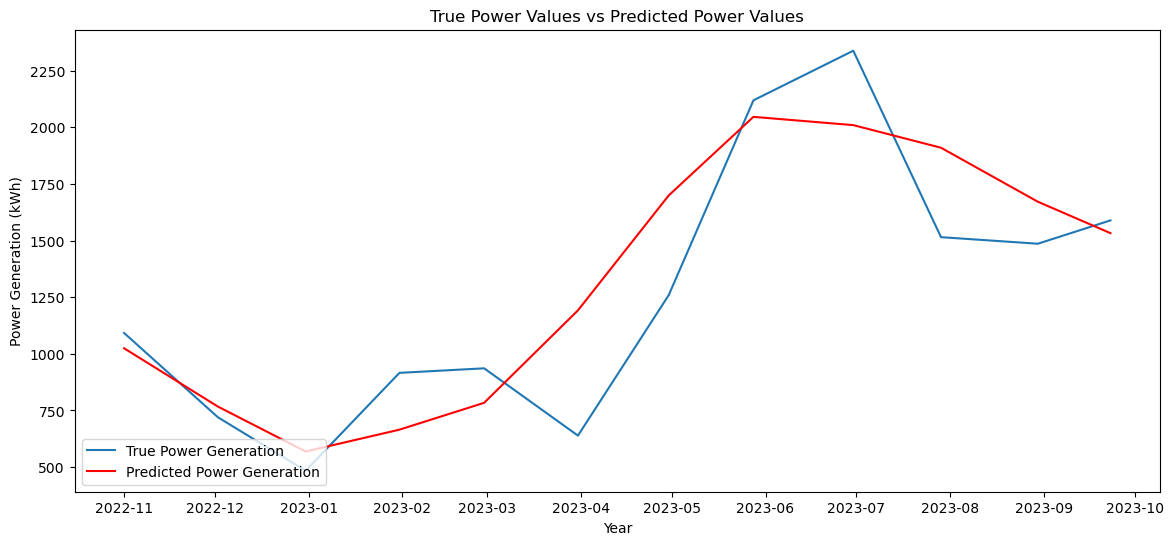

In [1827]:
plot_model(final_y_plotting)

In [1797]:
# plot truth and all predictions on one graph together 

# get the truth, data and prediction from one model 
preds_1 = final_y_plotting[['Date', 'Monthly Power Generation', 'Predicted Power']]

In [1798]:
# rename Predicted Power column 
preds_1.rename(columns={'Predicted Power': 'LSTM-RNN predictions'}, inplace=True)

C:\Users\afwil\AppData\Local\Temp\ipykernel_15328\1400361528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_1.rename(columns={'Predicted Power': 'LSTM-RNN predictions'}, inplace=True)


In [1852]:
norm_xgb_predictions =  norm_xgb_test_and_predicted['Predicted Power']
                                        
# add the xgb model predictions
preds_2 = pd.concat([preds_1, norm_xgb_predictions],axis=1)

# rename predicted power column
preds_2.rename(columns={'Predicted Power': 'XGB (with normalisation) predictions'}, inplace=True)

In [1853]:
xgb_predictions =  xgb_test_and_predicted['Predicted Power']
                                        
# add the xgb model predictions
preds_3 = pd.concat([preds_2, xgb_predictions],axis=1)

# rename predicted power column
preds_3.rename(columns={'Predicted Power': 'XGB predictions'}, inplace=True)

In [1855]:
sm1_predictions = sm_true_and_predicted['Predicted Power']
# add the first SARIMAX model 
preds_4 = pd.concat([preds_3, sm1_predictions],axis=1)
                                        
# rename predicted power column
preds_4.rename(columns={'Predicted Power': 'SARIMAX I predictions'}, inplace=True)

In [1860]:
sm2_predictions = es_sm_true_and_predicted['Predicted Power']

# add second SARIMAX model 
all_preds = pd.concat([preds_4, sm2_predictions],axis=1)
# rename predicted power column
all_preds.rename(columns={'Predicted Power': 'SARIMAX II predictions'}, inplace=True)

In [1861]:
all_preds

,Date,Monthly Power Generation,LSTM-RNN predictions,XGB (with normalisation) predictions,XGB predictions,SARIMAX I predictions,SARIMAX II predictions
0,2022-11-01,1092,1024.489502,1126.961304,1108.997437,896.922142,882.176618
1,2022-12-02,720,767.213562,749.974670,675.513611,693.946048,514.904470
2,2022-12-31,484,568.852112,741.346497,582.596985,412.306093,331.050884
3,2023-01-31,916,665.217712,850.914246,848.964111,546.226165,525.397344
4,2023-02-28,936,783.775696,795.514221,983.673340,805.649205,778.157664
5,2023-03-31,639,1191.893188,1199.068359,1441.532104,1211.831059,1001.519435
6,2023-04-30,1259,1699.193237,1421.172852,2167.199219,2105.904216,1972.994981
7,2023-05-28,2119,2046.041138,1538.034546,2709.561035,2450.803766,2457.687751
8,2023-06-30,2338,2009.574219,1745.019653,2285.429932,2282.175774,2199.693536
9,2023-07-29,1515,1909.738159,1611.699341,2383.594238,2331.039861,2159.976524


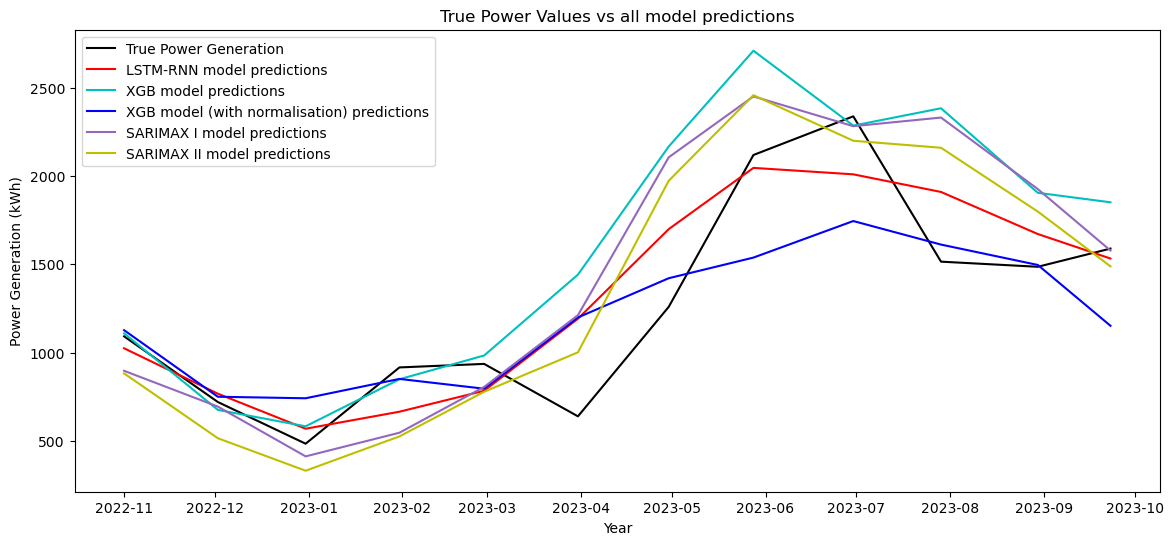

In [1863]:
# create the plot

plt.figure(figsize=(14,6))
plt.plot(all_preds.Date, all_preds['Monthly Power Generation'], color='k', label='True Power Generation')
plt.plot(all_preds.Date, all_preds['LSTM-RNN predictions'], color='r', label='LSTM-RNN model predictions')
plt.plot(all_preds.Date, all_preds['XGB predictions'], color='c', label='XGB model predictions')
plt.plot(all_preds.Date, all_preds['XGB (with normalisation) predictions'], color='b', label='XGB model (with normalisation) predictions')
plt.plot(all_preds.Date, all_preds['SARIMAX I predictions'], color='tab:purple', label='SARIMAX I model predictions')
plt.plot(all_preds.Date, all_preds['SARIMAX II predictions'], color='y', label='SARIMAX II model predictions')


plt.title('True Power Values vs all model predictions')
plt.xlabel('Year')
plt.ylabel('Power Generation (kWh)')
    
plt.legend(loc='upper left')

plt.show()